# Text Normalization

In [ ]:
import re
# Preprocessing function
def preprocess_text(text):
  text = text.lower() # Lowercase
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
  text = re.sub(r'\@\w+|\#', '', text) # Remove mentions/hashtags
  text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
  text = re.sub(r'\d+', '', text) # Remove numbers
  # Remove stopwords and lemmatize
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  tokens = text.split()
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
  return ' '.join(tokens)

# Data Pre - processing and Analysis:

In [ ]:
# Install and import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Load and Prepare Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Example dataset loading (to be replaced with actual dataset)
# Assume we have two columns: 'text' and 'label'
data = pd.read_csv('/content/drive/MyDrive/Sharing/trum_tweet_sentiment_analysis.csv')  # Replace with actual path
data.head()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0


Cleaning Data

In [ ]:
data['cleaned_text'] = data["text"].apply(lambda dataset: preprocess_text(dataset))

In [ ]:
data

,text,Sentiment,cleaned_text
0,RT @JohnLeguizamo: #trump not draining swamp b...,0,rt trump draining swamp taxpayer dollar trip a...
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0,icymi hacker rig fm radio station play antitru...
2,Trump protests: LGBTQ rally in New York https:...,1,trump protest lgbtq rally new york bbcworld via
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0,hi im pier morgan david beckham awful donald t...
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0,rt tech firm suing buzzfeed publishing unverif...
...,...,...,...
1850118,Everytime im like 'How the fuck I follow Melan...,0,everytime im like fuck follow melania trump re...
1850119,RT @imgur: The Trump Handshake. https://t.co/R...,0,rt trump handshake
1850120,"""Greenspan warns Trump's policies risk inflati...",0,greenspan warns trump policy risk inflation sp...
1850121,RT @FasinatingLogic: We must also #INVESTIGATE...,1,rt must also investigatethe voted allow releas...


## Basic Data Visualisation

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

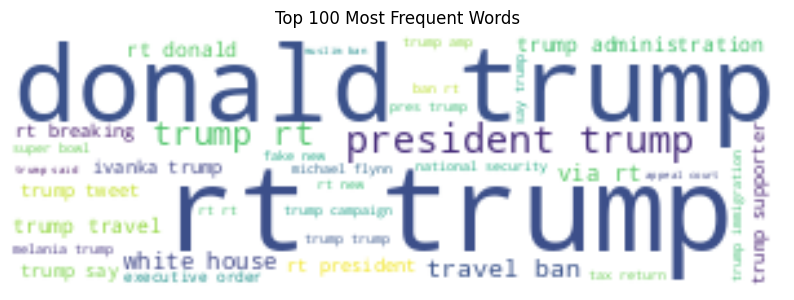

In [ ]:
# --- Visualization: Word Cloud (Top 100 Words) ---
all_words = ' '.join(data['cleaned_text'])
# Generate WordCloud with only top 100 words
wordcloud = WordCloud(
width=300,
height=100,
background_color='white',
max_words=100 # Limit to top 100 words
).generate(all_words)
# Plot settings
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

3.2 Tokenization and Padding

1. Split the Data

In [ ]:
from sklearn.model_selection import train_test_split
# Split FIRST (before tokenization)
X_train, X_test, y_train, y_test = train_test_split(
data['cleaned_text'], # Features (text)
data['Sentiment'], # Labels
test_size=0.2,
random_state=42
)

2. Basic Tokenization workflow with keras:

2.1 Tokenization Using Training Data:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train) # Vocabulary based ONLY on training data

In [ ]:
# Use the same tokenizer to transform both sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Percentile-Based Padding:

In [ ]:
import numpy as np

seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95)) # Covers 95% of sentences

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

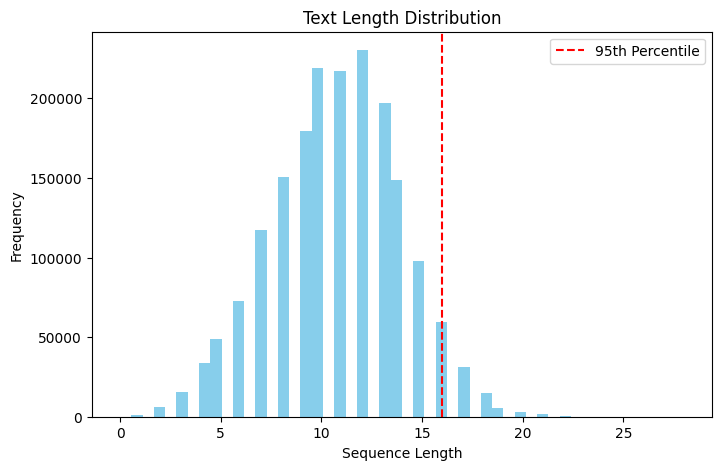

In [ ]:
X_seq = tokenizer.texts_to_sequences(data['cleaned_text'])
seq_lengths = [len(seq) for seq in X_seq]
plt.figure(figsize=(8, 5))
plt.hist(seq_lengths, bins=50, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(np.percentile(seq_lengths, 95), color='red', linestyle='dashed', label='95th Percentile')
plt.legend()
plt.show()

Model Creation

Two Models are implemented:

• Embedding Layer.

• Simple RNN.

• LSTM.

Embedding Layer

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
# # Example parameters
# vocab_size = 10000 # Size of vocabulary
# embedding_dim = 128 # Dimension of embedding vectors
# max_length = 100 # Maximum length of input sequences
# rnn_units = 64 # Number of RNN units
# # Build the model
# model = Sequential([
#   # Embedding layer converts word indices to dense vectors
#   Embedding(input_dim=vocab_size,
#   output_dim=embedding_dim,
#   input_length=max_length),
#   # RNN layer processes the sequence
#   SimpleRNN(units=rnn_units, return_sequences=False),
#   # Final dense layer for classification
#   Dense(1, activation='sigmoid')
# ])

Simple RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
# RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
rnn_model.add(SimpleRNN(64)) # Vanilla RNN layer
rnn_model.add(Dense(3, activation='softmax')) # For 3 sentiment classes
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
# LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
lstm_model.add(LSTM(64)) # LSTM layer
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_pad, X_val_pad, y_train, y_val = train_test_split(
    X_train_pad, y_train, test_size=0.2, random_state=42
)

In [ ]:
# Common for both RNN and LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Save the best model
checkpoint = ModelCheckpoint('best_rnn_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Stop training early if validation loss doesn’t improve
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
history = rnn_model.fit(
X_train_pad, y_train,
epochs=10,
batch_size=64,
validation_data=(X_val_pad, y_val),
callbacks=[checkpoint, early_stop]
)

Epoch 1/10
14801/14801 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9784 - loss: 0.0644
Epoch 1: val_accuracy improved from -inf to 0.97422, saving model to best_rnn_model.h5


14801/14801 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 0.9784 - loss: 0.0644 - val_accuracy: 0.9742 - val_loss: 0.0741
Epoch 2/10
14788/14801 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9789 - loss: 0.0625
Epoch 2: val_accuracy did not improve from 0.97422
14801/14801 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.9789 - loss: 0.0625 - val_accuracy: 0.9716 - val_loss: 0.0822
Epoch 3/10
14796/14801 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9796 - loss: 0.0616
Epoch 3: val_accuracy did not improve from 0.97422
14801/14801 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9796 - loss: 0.0616 - val_accuracy: 0.9730 - val_loss: 0.0802
Epoch 4/10
14794/14801 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9794 - loss: 0.0613
Epoch 4: val_accuracy did not improve from 0.97422
14801/14801 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9794 - loss: 0.0613 - val_accuracy: 0.9697 - val_loss: 0.0882
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


3.5 Results and Evaluation:

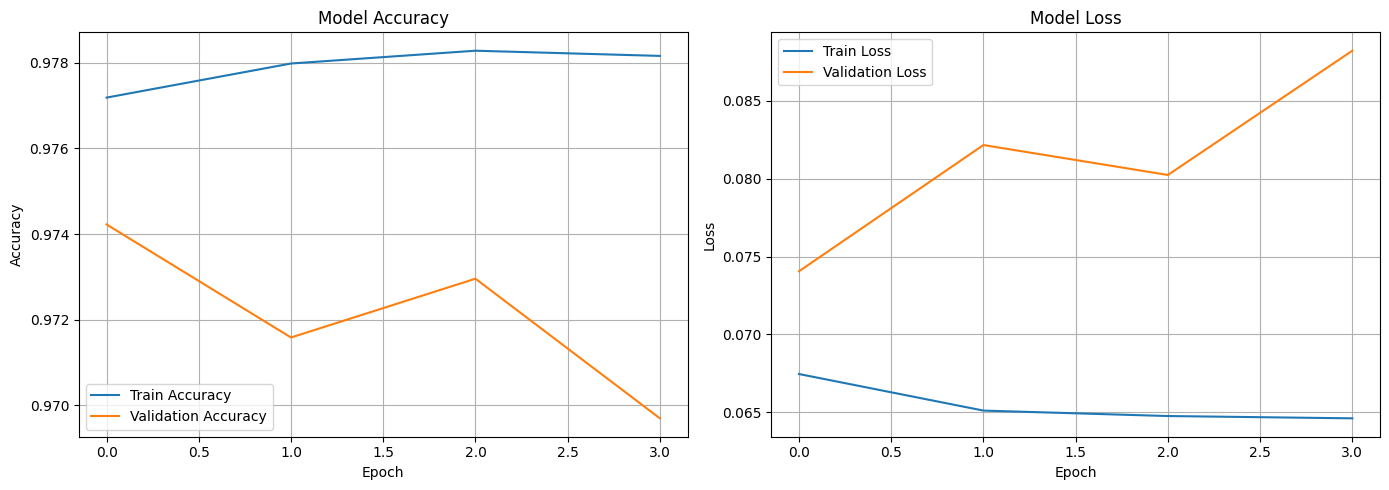

In [ ]:
# Plotting training/validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Predictions on the validation set
y_pred_rnn = rnn_model.predict(X_val_pad)
y_pred_classes = np.argmax(y_pred_rnn, axis=1) # Convert probabilities to class labels
# Accuracy score
accuracy = accuracy_score(y_val, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

7401/7401 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
Accuracy: 0.9742


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[156883   2404]
 [  3700  73829]]


In [ ]:
# Classification Report
cr = classification_report(y_val, y_pred_classes)  # Remove target_names
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    159287
           1       0.97      0.95      0.96     77529

    accuracy                           0.97    236816
   macro avg       0.97      0.97      0.97    236816
weighted avg       0.97      0.97      0.97    236816

